In [19]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


import os
import PIL
import torch
import random
import pandas as pd
from torch import nn
from PIL import Image
import seaborn as sns
from tqdm.auto import tqdm
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from torchvision.transforms import ToPILImage
from typing import Optional, List, Any, Tuple

In [20]:
CARTOON_FACES_DATASET_PATH = "./datasets/cartoonset100k_jpg"
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 128
NOISE_SIZE = 128
GENERATOR_LEARNING_RATE = 0.0002 * (BATCH_SIZE / 128)
DISCRIMINATOR_LEARNING_RATE = 0.0001 * (BATCH_SIZE / 128)
BETA_1 = 0.0
BETA_2 = 0.9
NUM_EPOCHS = 100
SAVE_GENERATOR_DIRECTORY = "./checkpoints/dcgan_wgan_gp_3"
SAVE_DISCRIMINATOR_DIRECTORY = "./checkpoints/dcgan_wgan_gp_3"
SAVE_FAKE_IMAGES_PATH = "./fake_images/dcgan_wgan_gp_3"
SAVE_LOGS_PATH = "./logs/dcgan_wgan_gp_3/gan_training_logs.csv"

In [21]:
class CartoonFacesDataset(Dataset):
    def __init__(self,
                 root,
                 transform=None,
                 include_folders: Optional[List[str]] = None):
        self.root = root
        self.transform = transform
        if include_folders is None:
            self.folders = [d for d in os.listdir(self.root) if os.path.isdir(os.path.join(self.root, d))]
        else:
            self.folders = include_folders
        self.data = []
        for folder in self.folders:
            images_folder = os.path.join(self.root, folder)
            for file_name in os.listdir(images_folder):
                if file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                    image_path = os.path.join(images_folder, file_name)
                    self.data.append(image_path)

    def __len__(self):
        return len(self.data)

    def __getitem__(self,
                    idx: int):
        image_path = self.data[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

In [22]:
cartoon_faces_dataset = CartoonFacesDataset(root=CARTOON_FACES_DATASET_PATH, include_folders=["0"])

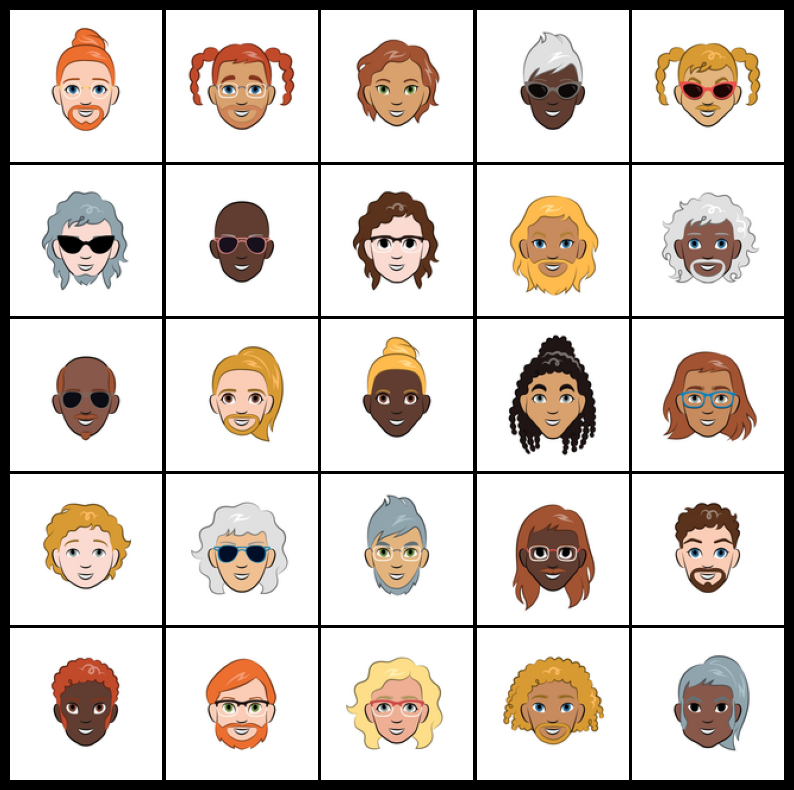

In [23]:
random.seed(42)
random_images_idx = [random.randint(0, len(cartoon_faces_dataset) - 1) for _ in range(25)]
plt.figure(figsize=(10, 10), facecolor='black')
plt.subplots_adjust(wspace=0.02, hspace=0.02)
for i, image_idx in enumerate(random_images_idx):
    image = cartoon_faces_dataset[image_idx]
    image = image.resize(IMAGE_SIZE, resample=Image.LANCZOS)
    plt.subplot(5, 5, i+1)
    plt.imshow(image)
    plt.axis("off")
plt.show()

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [25]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [26]:
class Generator(nn.Module):
    def __init__(self,
                 noise_size: int = 128,
                 feature_maps_size: int = 64,
                 image_channels: int = 3):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(noise_size, feature_maps_size * 16, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(feature_maps_size * 16),
            nn.ReLU(True),

            nn.ConvTranspose2d(feature_maps_size * 16, feature_maps_size * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_maps_size * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(feature_maps_size * 8, feature_maps_size * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_maps_size * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(feature_maps_size * 4, feature_maps_size * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_maps_size * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(feature_maps_size * 2, feature_maps_size, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(feature_maps_size),
            nn.ReLU(True),

            nn.ConvTranspose2d(feature_maps_size, image_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, input_tensor: torch.Tensor) -> torch.Tensor:
        return self.main(input_tensor)

In [27]:
generator = Generator().to(device)
generator.apply(weights_init_normal)
print(generator)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(128, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchN

In [28]:
class Discriminator(nn.Module):
    def __init__(self,
                 feature_maps_size: int = 64,
                 image_channels: int = 3):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(image_channels, feature_maps_size, kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(feature_maps_size, affine=True),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feature_maps_size, feature_maps_size * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(feature_maps_size * 2, affine=True),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feature_maps_size * 2, feature_maps_size * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(feature_maps_size * 4, affine=True),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feature_maps_size * 4, feature_maps_size * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(feature_maps_size * 8, affine=True),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feature_maps_size * 8, feature_maps_size * 16, kernel_size=4, stride=2, padding=1, bias=False),
            nn.InstanceNorm2d(feature_maps_size * 16, affine=True),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(feature_maps_size * 16, 1, kernel_size=4, stride=1, padding=0, bias=False)
        )

    def forward(self, input_tensor: torch.Tensor) -> torch.Tensor:
        out = self.main(input_tensor)
        return out.squeeze()

In [29]:
discriminator = Discriminator().to(device)
discriminator.apply(weights_init_normal)
print(discriminator)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Conv2d(512, 

In [30]:
def tensors_to_images(tensor: torch.Tensor) -> List[PIL.Image.Image]:
    to_pil = ToPILImage()
    return [to_pil((fake_image + 1) / 2) for fake_image in tensor]


def save_checkpoint(model: nn.Module,
                    optimizer: Any = None,
                    scheduler: Any = None,
                    epoch: Optional[int] = None,
                    path: str = None) -> None:
    checkpoint = {}
    checkpoint["model_state_dict"] = model.state_dict()
    if optimizer is not None:
        checkpoint["optimizer_state_dict"] = optimizer.state_dict()
    if scheduler is not None:
        checkpoint["scheduler_state_dict"] = scheduler.state_dict()
    if epoch is not None:
        checkpoint["epoch"] = epoch
    torch.save(checkpoint, path)


def load_checkpoint(model: nn.Module,
                    optimizer: Any = None,
                    scheduler: Any = None,
                    path: str = None) -> int:
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint["model_state_dict"])
    if optimizer is not None and "optimizer_state_dict" in checkpoint:
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    if scheduler is not None and "scheduler_state_dict" in checkpoint:
        scheduler.load_state_dict(checkpoint["scheduler_state_dict"])
    if "epoch" in checkpoint:
        return checkpoint["epoch"]
    return 0


def gradient_penalty(discriminator, real_images, fake_images, device):
    batch_size = real_images.size(0)
    eps = torch.rand(batch_size, 1, 1, 1, device=device, requires_grad=True)
    inter = eps * real_images + (1 - eps) * fake_images
    d_inter = discriminator(inter)
    grads = torch.autograd.grad(outputs=d_inter,
                                inputs=inter,
                                grad_outputs=torch.ones_like(d_inter),
                                create_graph=True,
                                retain_graph=True)[0]
    grads = grads.view(batch_size,-1)
    gp = ((grads.norm(2,dim=1)-1)**2).mean()
    return gp


def train_gan(generator: nn.Module,
              discriminator: nn.Module,
              dataloader: DataLoader,
              generator_optimizer: Any,
              discriminator_optimizer: Any,
              num_epochs: int,
              discriminator_iteration_per_batch: int = 1,
              noise_size: int = 128,
              gp_lambda: float = 10.0,
              fixed_noises: torch.Tensor = None,
              save_fake_images_path: Optional[str] = None,
              save_generator_directory: Optional[str] = None,
              save_discriminator_directory: Optional[str] = None,
              load_generator_checkpoint_path: Optional[str] = None,
              load_discriminator_checkpoint_path: Optional[str] = None,
              log_file_path: Optional[str] = None,
              show_fake_images: bool = True,
              fake_images_grid_size: Optional[Tuple[int, int]] = None,
              fake_images_figure_size: Optional[Tuple[int, int]] = None,
              verbose: bool = True) -> pd.DataFrame:
    start_epoch = 0
    device = next(generator.parameters()).device
    if load_generator_checkpoint_path is not None:
        start_epoch = load_checkpoint(generator,
                                      optimizer=generator_optimizer,
                                      path=load_generator_checkpoint_path)
    if load_discriminator_checkpoint_path is not None:
        start_epoch = load_checkpoint(discriminator,
                                      optimizer=discriminator_optimizer,
                                      path=load_discriminator_checkpoint_path)
    result_df = pd.DataFrame(columns=["epoch", "batch", "generator_loss", "discriminator_loss", "discriminator_real_loss", "discriminator_fake_loss", "w_gap", "gradient_penalty", "drift_penalty"])
    for epoch in range(start_epoch, num_epochs):
        generator_running_loss = 0.0
        discriminator_running_loss = 0.0
        w_gap = 0.0
        pbar = tqdm(dataloader, total=len(dataloader), disable=not verbose)
        pbar.set_description(f"Epoch: {epoch+1}/{num_epochs} Generator Loss: {generator_running_loss:.4f} Discriminator Loss: {discriminator_running_loss:.4f} Wasserstein gap: {w_gap:.4f}")
        generator.train()
        discriminator.train()
        for i, real_images in enumerate(pbar):
            real_images = real_images.to(device)
            batch_size = real_images.size(0)

            discriminator_loss = None
            discriminator_real_loss = None
            discriminator_fake_loss = None
            drift_penalty = None
            gp = None
            for _ in range(discriminator_iteration_per_batch):
                noise = torch.randn(batch_size, noise_size, 1, 1, device=device)
                fake_images = generator(noise).detach()
                discriminator_optimizer.zero_grad()
                real_output = discriminator(real_images)
                fake_output = discriminator(fake_images)
                discriminator_real_loss = real_output.mean()
                discriminator_fake_loss = fake_output.mean()
                gp = gradient_penalty(discriminator, real_images, fake_images, device)
                drift_penalty = 0.001 * torch.mean(real_output ** 2)
                discriminator_loss = (
                    discriminator_fake_loss
                    - discriminator_real_loss
                    + gp_lambda * gp
                    + drift_penalty
                )
                discriminator_loss.backward()
                discriminator_optimizer.step()
                w_gap = discriminator_real_loss.item() - discriminator_fake_loss.item()

            noise = torch.randn(batch_size, noise_size, 1, 1, device=device)
            generator_optimizer.zero_grad()
            fake_images = generator(noise)
            output = discriminator(fake_images)
            generator_loss = -output.mean()
            generator_loss.backward()
            generator_optimizer.step()

            discriminator_running_loss = discriminator_loss.item() if discriminator_loss is not None else 0
            generator_running_loss = generator_loss.item()
            pbar.set_description(f"Epoch: {epoch+1}/{num_epochs} Generator Loss: {generator_running_loss:.4f} Discriminator Loss: {discriminator_running_loss:.4f} Wasserstein gap: {w_gap:.4f}")
            result_df.loc[len(result_df)] = [
                epoch + 1,
                i + 1,
                generator_running_loss,
                discriminator_running_loss,
                discriminator_real_loss.item() if discriminator_real_loss is not None else 0,
                discriminator_fake_loss.item() if discriminator_fake_loss is not None else 0,
                w_gap,
                gp.item() if gp is not None else 0,
                drift_penalty.item() if drift_penalty is not None else 0
            ]

        generator.eval()
        discriminator.eval()
        if log_file_path is not None:
            result_df.to_csv(log_file_path, index=False)
        if save_generator_directory is not None:
            save_generator_checkpoint_path = os.path.join(save_generator_directory, f"generator_checkpoint_{epoch+1}.pth")
            save_checkpoint(generator, optimizer=generator_optimizer, epoch=epoch + 1, path=save_generator_checkpoint_path)
        if save_discriminator_directory is not None:
            save_discriminator_checkpoint_path = os.path.join(save_discriminator_directory, f"discriminator_checkpoint_{epoch+1}.pth")
            save_checkpoint(discriminator, optimizer=discriminator_optimizer, epoch=epoch + 1, path=save_discriminator_checkpoint_path)
        if fixed_noises is not None:
            with torch.no_grad():
                fake_images = generator(fixed_noises.to(device)).detach().cpu()
            fake_images = tensors_to_images(fake_images)
            if save_fake_images_path is not None:
                epoch_dir = os.path.join(save_fake_images_path, f"{epoch+1}")
                os.makedirs(epoch_dir, exist_ok=True)
                for i, fake_image in enumerate(fake_images):
                    fake_image.save(os.path.join(epoch_dir, f"{i}.png"))
            if show_fake_images and fake_images_grid_size is not None:
                rows, cols = fake_images_grid_size
                if fake_images_figure_size is not None:
                    plt.figure(figsize=fake_images_figure_size, facecolor='black')
                else:
                    plt.figure(figsize=(cols, rows), facecolor='black')
                plt.subplots_adjust(wspace=0.02, hspace=0.02)
                for i, fake_image in enumerate(fake_images):
                    plt.subplot(rows, cols, i+1)
                    plt.imshow(fake_image)
                    plt.axis("off")
                plt.show()
    return result_df

In [31]:
transform = transforms.Compose([
                               transforms.Resize(IMAGE_SIZE),
                               transforms.CenterCrop(IMAGE_SIZE),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])
cartoon_faces_dataset.transform = transform
dataloader = torch.utils.data.DataLoader(cartoon_faces_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, pin_memory_device=device)

In [32]:
generator_optimizer = optim.Adam(generator.parameters(), lr=GENERATOR_LEARNING_RATE, betas=(BETA_1, BETA_2))
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=DISCRIMINATOR_LEARNING_RATE, betas=(BETA_1, BETA_2))
g = torch.Generator(device=device).manual_seed(42)
fixed_noises = torch.randn(16, NOISE_SIZE, 1, 1, generator=g, device=device)

In [33]:
result_df = train_gan(generator=generator,
                      discriminator=discriminator,
                      dataloader=dataloader,
                      generator_optimizer=generator_optimizer,
                      discriminator_optimizer=discriminator_optimizer,
                      num_epochs=NUM_EPOCHS,
                      noise_size=NOISE_SIZE,
                      fixed_noises=fixed_noises,
                      save_generator_directory=SAVE_GENERATOR_DIRECTORY,
                      save_discriminator_directory=SAVE_DISCRIMINATOR_DIRECTORY,
                      save_fake_images_path=SAVE_FAKE_IMAGES_PATH,
                      log_file_path=SAVE_LOGS_PATH,
                      show_fake_images = True,
                      fake_images_grid_size = (4, 4),
                      fake_images_figure_size=(8, 8))

  0%|          | 0/79 [00:00<?, ?it/s]

KeyboardInterrupt: 

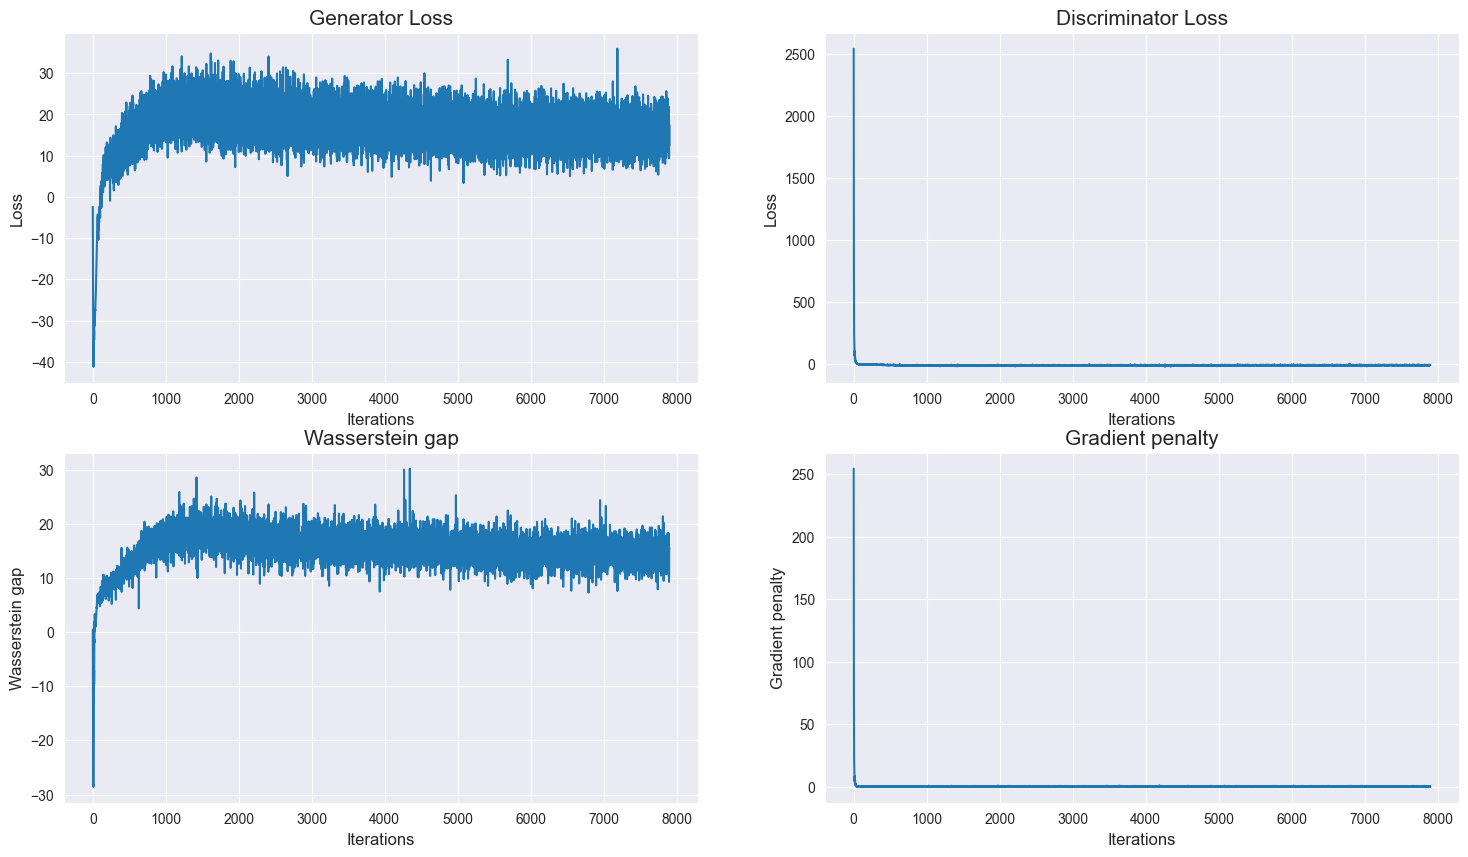

In [34]:
plt.figure(figsize=(18,10))
sns.set_style("darkgrid")

plt.subplot(2, 2, 1)
plt.title("Generator Loss",fontsize=15)
plt.xlabel("Iterations",fontsize=12)
plt.ylabel("Loss",fontsize=12)
plt.plot(result_df["generator_loss"])

plt.subplot(2, 2, 2)
plt.title("Discriminator Loss",fontsize=15)
plt.xlabel("Iterations",fontsize=12)
plt.ylabel("Loss",fontsize=12)
plt.plot(result_df["discriminator_loss"])

plt.subplot(2, 2, 3)
plt.title("Wasserstein gap",fontsize=15)
plt.xlabel("Iterations",fontsize=12)
plt.ylabel("Wasserstein gap",fontsize=12)
plt.plot(result_df["w_gap"])

plt.subplot(2, 2, 4)
plt.title("Gradient penalty",fontsize=15)
plt.xlabel("Iterations",fontsize=12)
plt.ylabel("Gradient penalty",fontsize=12)
plt.plot(result_df["gradient_penalty"])

plt.show()

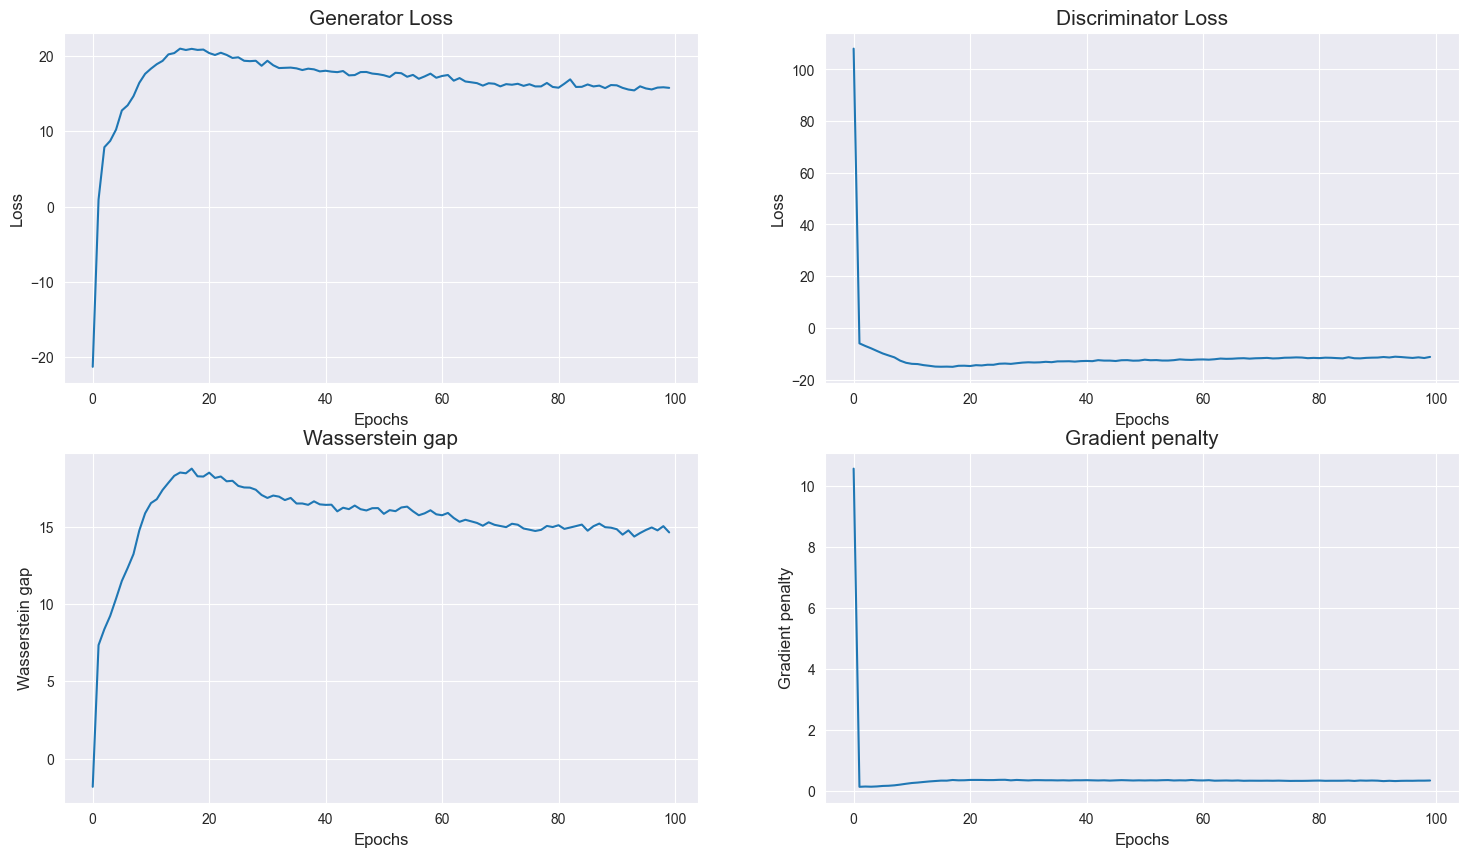

In [35]:
result_df_over_epochs = result_df.groupby("epoch")[["generator_loss", "discriminator_loss", "discriminator_real_loss", "discriminator_fake_loss", "w_gap", "gradient_penalty", "drift_penalty"]].mean().reset_index()

plt.figure(figsize=(18,10))
sns.set_style("darkgrid")

plt.subplot(2, 2, 1)
plt.title("Generator Loss",fontsize=15)
plt.xlabel("Epochs",fontsize=12)
plt.ylabel("Loss",fontsize=12)
plt.plot(result_df_over_epochs["generator_loss"])

plt.subplot(2, 2, 2)
plt.title("Discriminator Loss",fontsize=15)
plt.xlabel("Epochs",fontsize=12)
plt.ylabel("Loss",fontsize=12)
plt.plot(result_df_over_epochs["discriminator_loss"])

plt.subplot(2, 2, 3)
plt.title("Wasserstein gap",fontsize=15)
plt.xlabel("Epochs",fontsize=12)
plt.ylabel("Wasserstein gap",fontsize=12)
plt.plot(result_df_over_epochs["w_gap"])

plt.subplot(2, 2, 4)
plt.title("Gradient penalty",fontsize=15)
plt.xlabel("Epochs",fontsize=12)
plt.ylabel("Gradient penalty",fontsize=12)
plt.plot(result_df_over_epochs["gradient_penalty"])

plt.show()

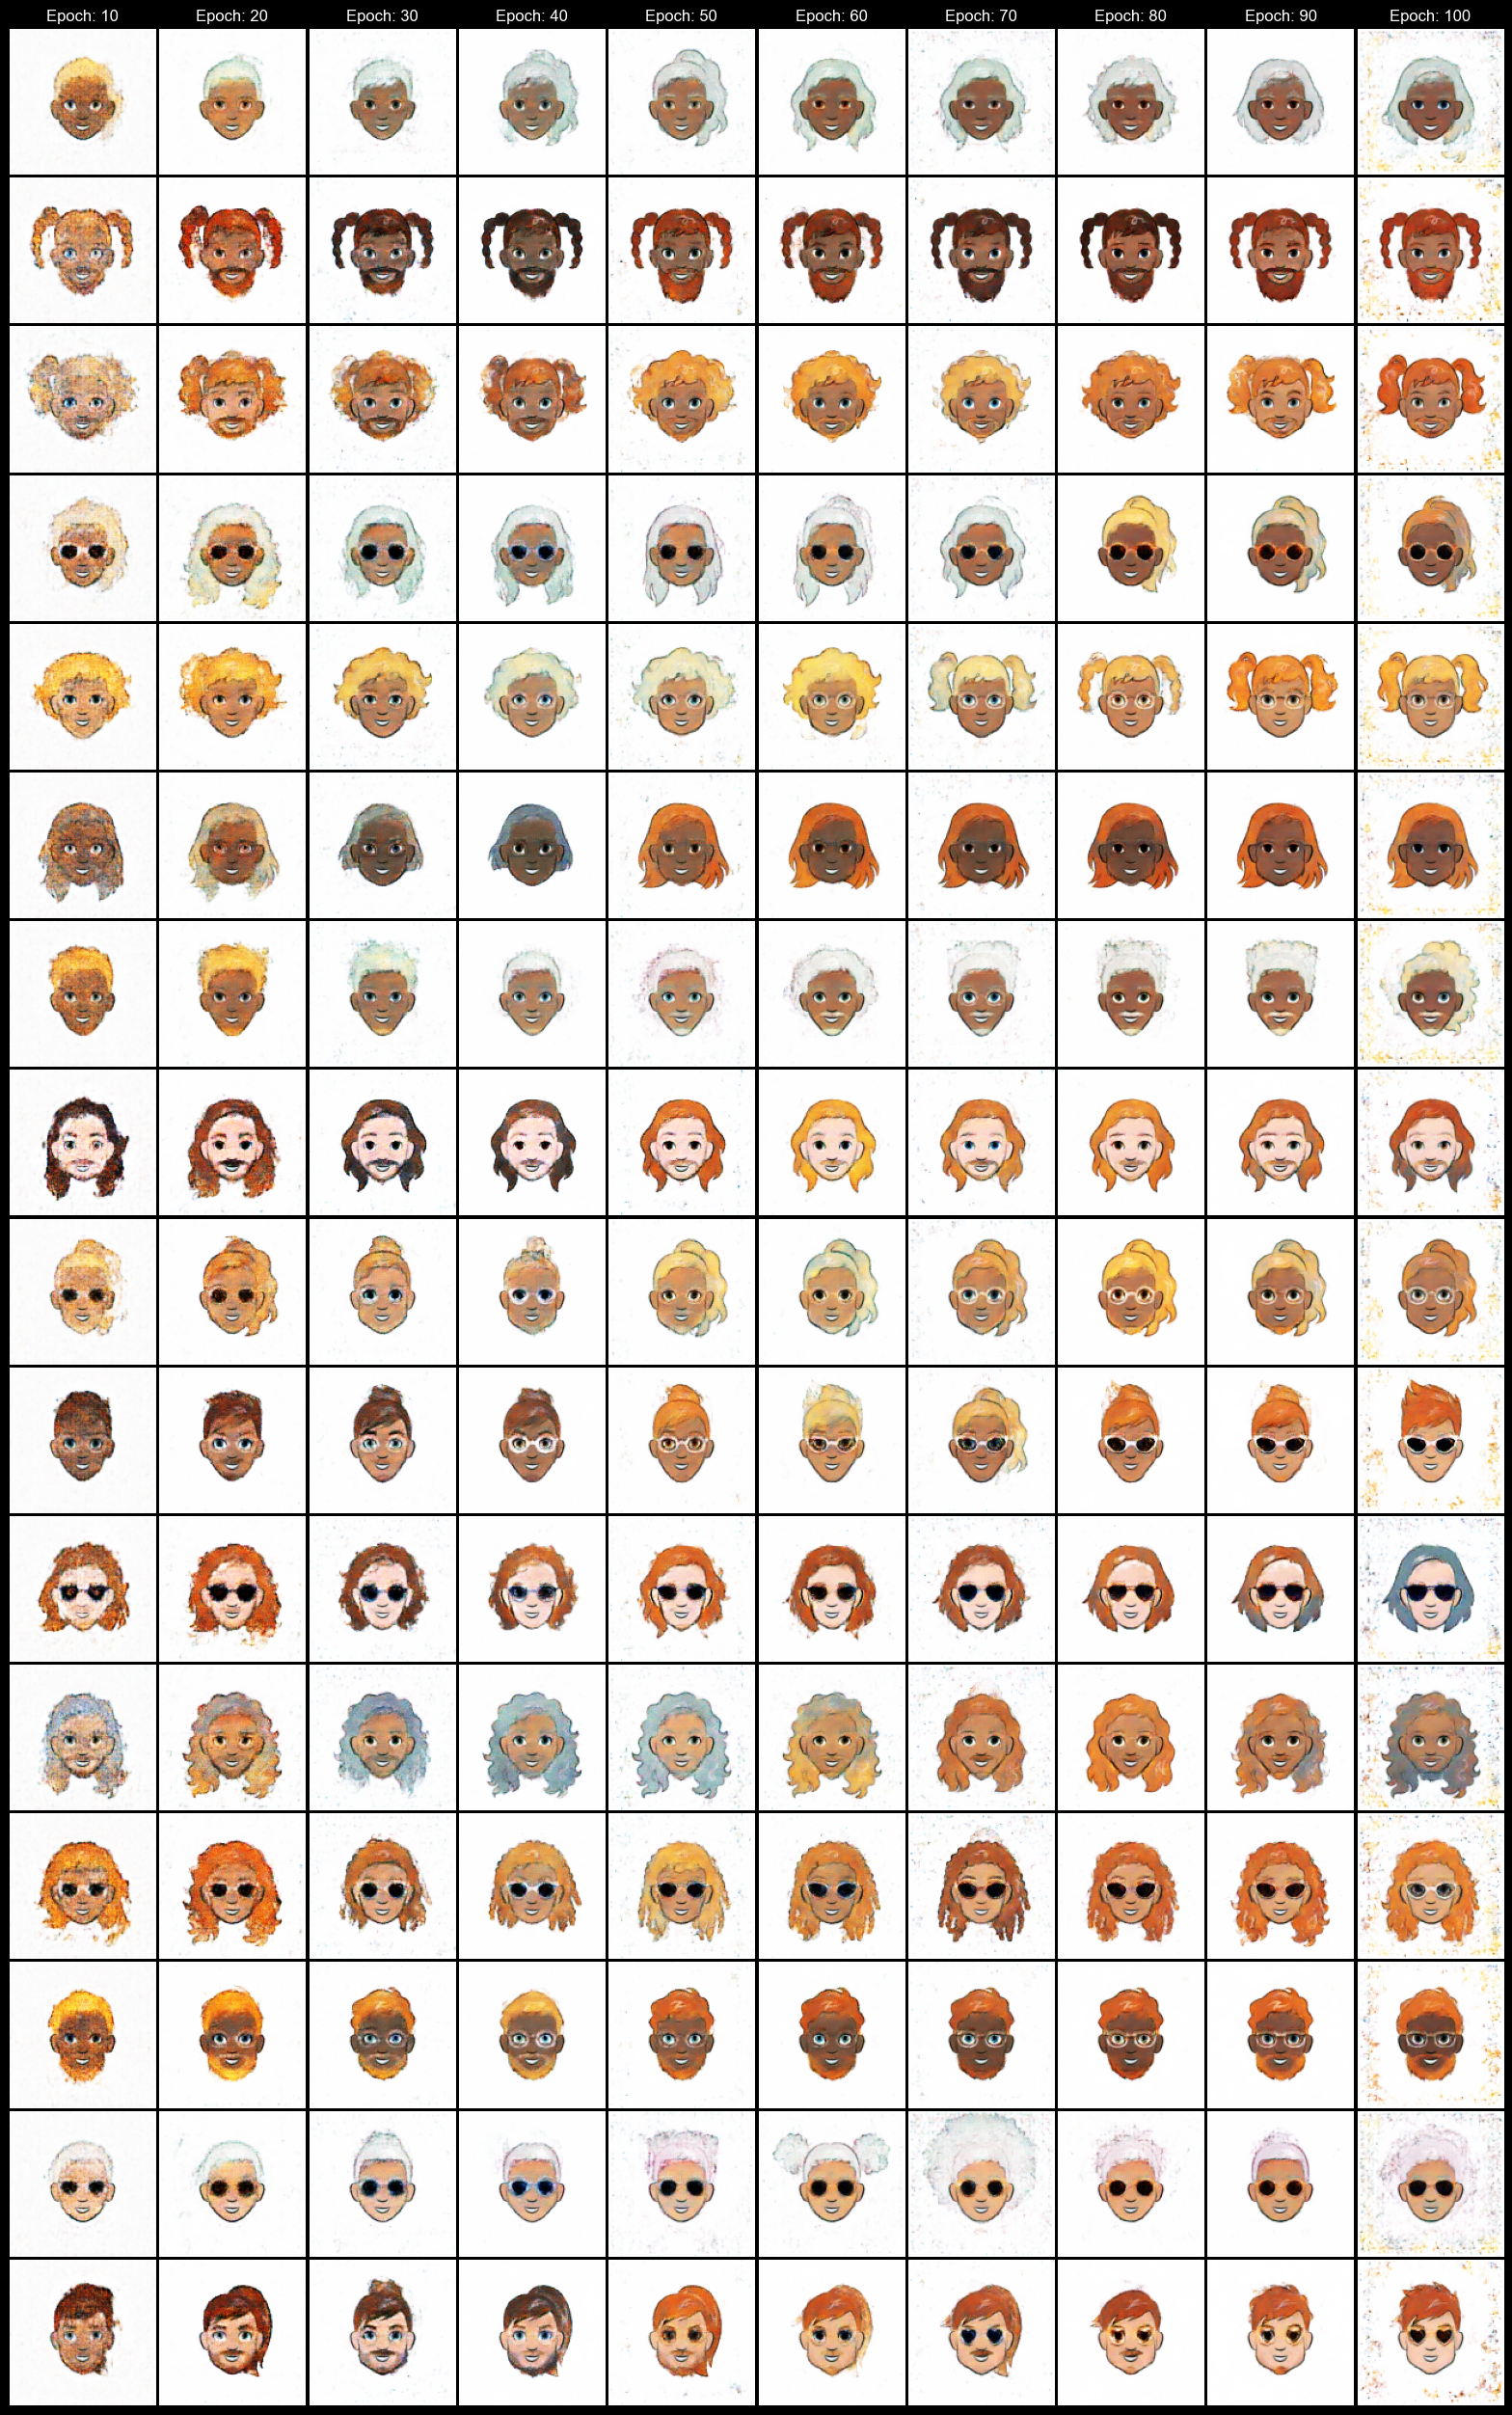

In [36]:
plt.figure(figsize=(20, 32), facecolor='black')
plt.subplots_adjust(wspace=0.02, hspace=0.02)
for i in range(0, 16):
    for j in range(10, 110, 10):
        image_path = os.path.join(SAVE_FAKE_IMAGES_PATH, str(j), f"{i}.png")
        image = Image.open(image_path)
        plt.subplot(16, 10, i * 10 + (j // 10))
        plt.imshow(image)
        if i == 0:
            plt.title(f"Epoch: {j}", fontsize=12, color="white")
        plt.axis("off")
plt.show()

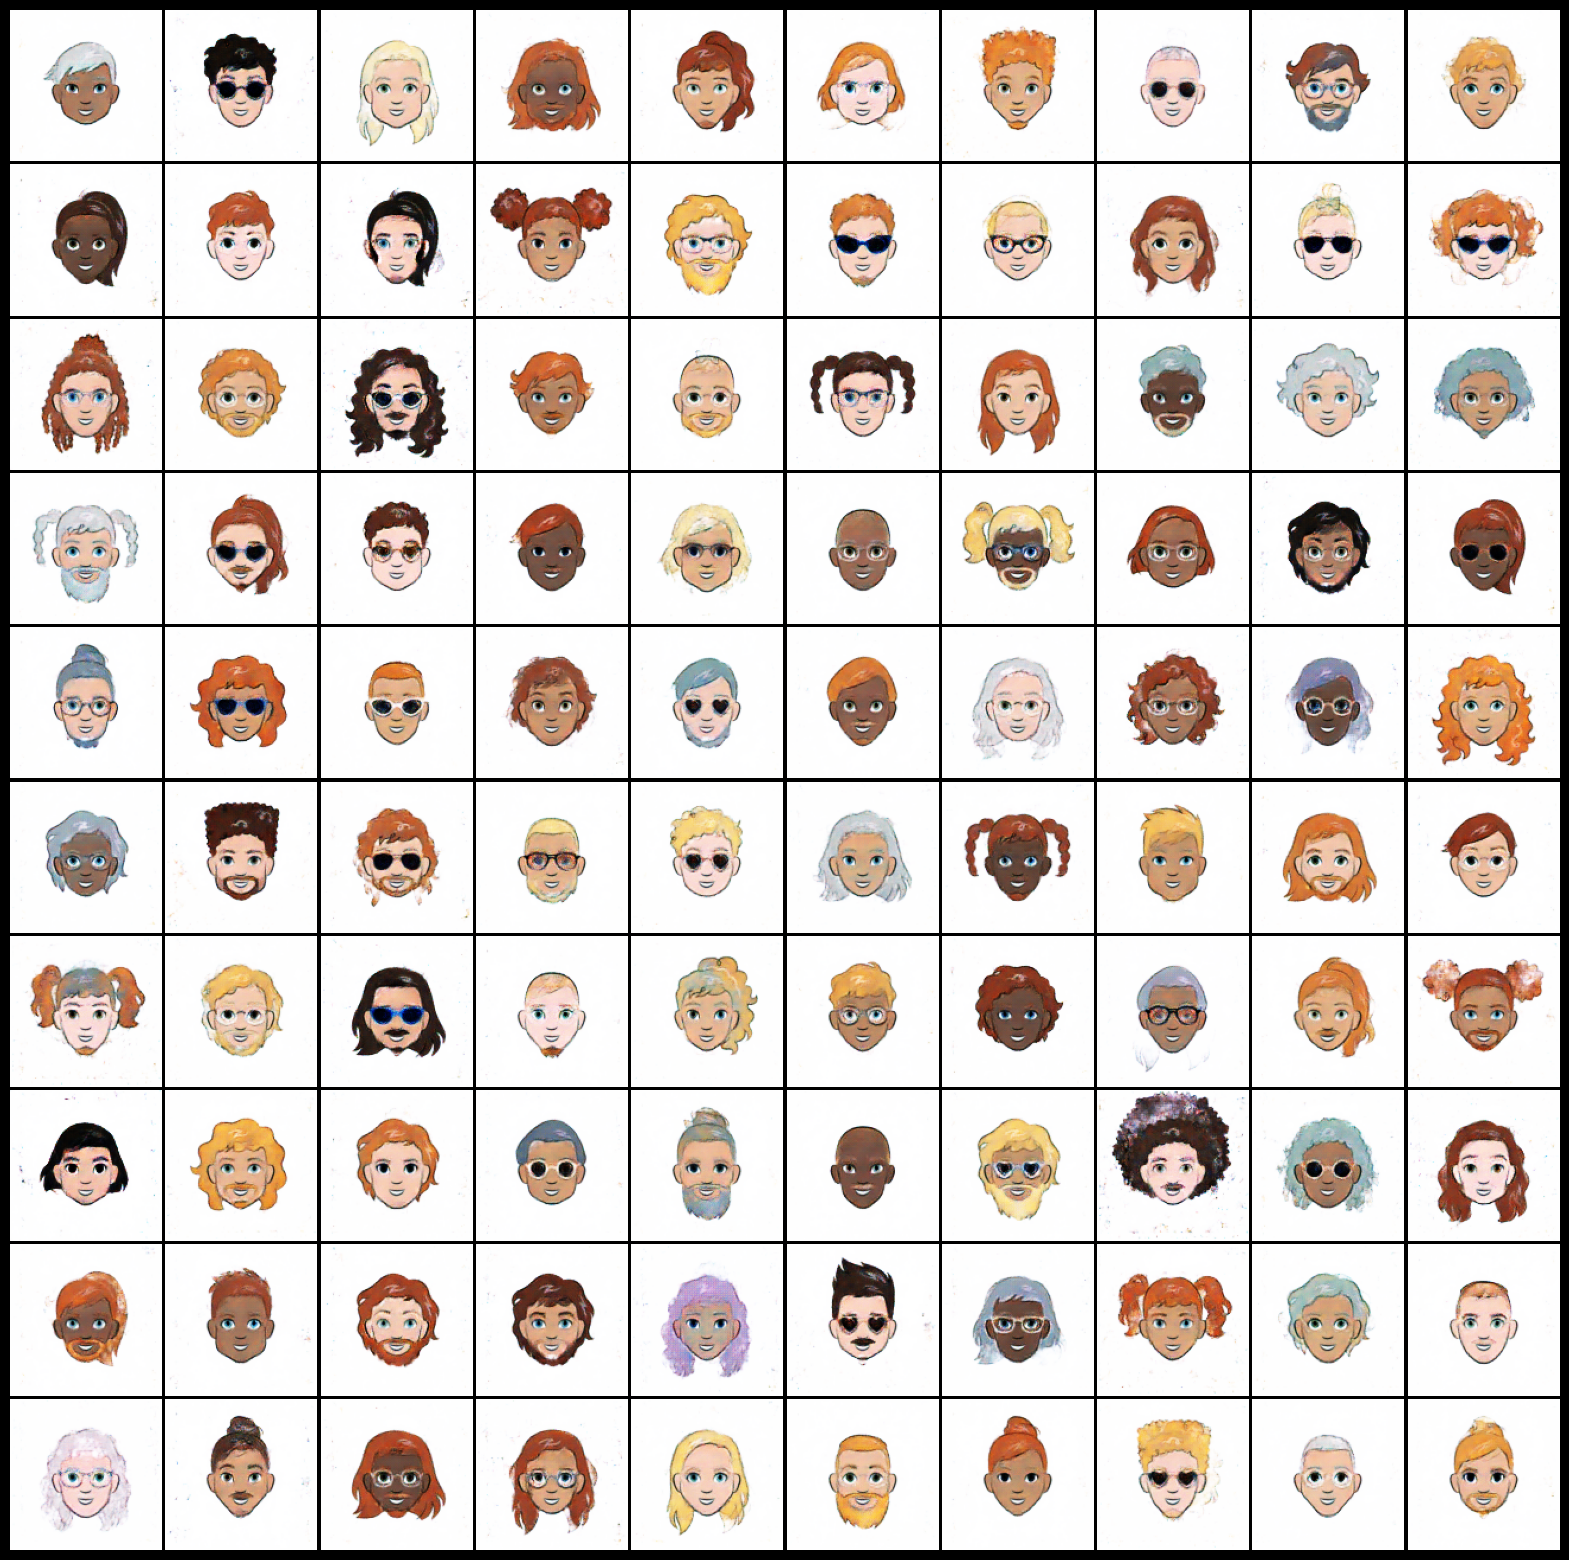

In [39]:
random_noise = torch.randn(100, NOISE_SIZE, 1, 1, device=device)
with torch.no_grad():
    generated_images = generator(random_noise)
    images = tensors_to_images(generated_images)
plt.figure(figsize=(20, 20), facecolor='black')
plt.subplots_adjust(wspace=0.02, hspace=0.02)
for i, image in enumerate(images):
    plt.subplot(10, 10, i + 1)
    plt.imshow(image)
    plt.axis("off")
plt.show()